# Download LANDFIRE Landscape Data

**What this notebook does:**
1. Define a location (lat/lon) and radius
2. Query LANDFIRE for landscape layers
3. Download and extract rasters (.tif and .asc)
4. Visualize the results

**LANDFIRE layers retrieved:**
- **Canopy**: Bulk Density, Base Height, Cover, Height
- **Fuel**: Fire Behavior Fuel Models (FBFM40)
- **Terrain**: Elevation, Slope, Aspect

**Requirements:**
- Valid email address
- Internet connection
- ~5-10 min wait time for processing

---

## Setup

In [1]:
import os
import time
import requests
import zipfile
import io
from pathlib import Path

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Point
from osgeo import gdal

gdal.UseExceptions()  # Better error messages

print("✓ Imports loaded")

✓ Imports loaded


## 1. Define Your Area of Interest

Change these values to your fire location:

In [2]:
# ========== USER INPUTS ==========

FIRE_NAME = "Maria Fire"            # For naming output directory
CENTER_LAT = 34.302                 # Fire location latitude
CENTER_LON = -118.997               # Fire location longitude
RADIUS_MILES = 10                   # Download area radius

YOUR_EMAIL = "h7ahmed@ucsd.edu"  # REQUIRED: REPLACE WITH VALID EMAIL

# ==================================

## 2. Create Bounding Box

Buffer the point by the radius to create a rectangular download area:

In [3]:
# Create point and buffer in accurate projection
point_wgs84 = gpd.GeoSeries([Point(CENTER_LON, CENTER_LAT)], crs="EPSG:4326")
point_utm = point_wgs84.to_crs(point_wgs84.estimate_utm_crs())

radius_m = RADIUS_MILES * 1609.34  # miles to meters
buffer_utm = point_utm.buffer(radius_m)

# Get bounding box in WGS84
minx, miny, maxx, maxy = buffer_utm.to_crs("EPSG:4326").total_bounds

print(f"Bounding box: [{minx:.4f}, {miny:.4f}, {maxx:.4f}, {maxy:.4f}]")
print(f"Area: ~{(maxx - minx) * (maxy - miny) * 111**2:.1f} km²")
print(f"✓ AOI defined")

Bounding box: [-119.1718, 34.1569, -118.8222, 34.4470]
Area: ~1249.5 km²
✓ AOI defined


## 3. Submit LANDFIRE Request

This sends a job to LANDFIRE's API to generate the rasters:

In [4]:
# LANDFIRE API endpoint
LFPS_URL = "https://lfps.usgs.gov/api/job/submit"

# Request parameters
params = {
    "Email": YOUR_EMAIL,
    "Layer_List": "250CBD;250CBH;250CC;250CH;250FBFM40;ASP2020;ELEV2020;SLPP2020",
    "Area_of_Interest": f"{minx} {miny} {maxx} {maxy}",
    "Output_Projection": "5070",      # NAD83 Albers (FARSITE standard)
    "Resample_Resolution": "90",      # 90m resolution
    "Priority_Code": "K3LS9F"         # Standard priority
}

# Submit job
print("Submitting request to LANDFIRE...")
response = requests.get(LFPS_URL, params=params, timeout=30)
response.raise_for_status()

job_id = response.json()["jobId"]
print(f"✓ Job submitted: {job_id}")

Submitting request to LANDFIRE...
✓ Job submitted: 361035f6-a84c-48b7-8e78-a6dc1b29f3bb


## 4. Wait for Processing

This typically takes between 1 to 5 minutes. The cell will poll the job status every 10 seconds:

In [5]:
status_url = f"https://lfps.usgs.gov/api/job/status?JobId={job_id}"

print("Waiting for LANDFIRE to process request...")
print("Status checks:")

start_time = time.time()
while True:
    response = requests.get(status_url, timeout=30)
    status_data = response.json()
    status = status_data.get("status", "").lower()
    
    elapsed = int(time.time() - start_time)
    print(f"  [{elapsed}s] {status}")
    
    if status == "succeeded":
        print(f"\n✓ Job completed in {elapsed}s")
        download_url = status_data["outputFile"]
        break
    elif status in ("failed", "canceled"):
        raise RuntimeError(f"LANDFIRE job {status}: {status_data.get('message', 'Unknown error')}")
    
    time.sleep(10)  # Check every 10 seconds

Waiting for LANDFIRE to process request...
Status checks:
  [0s] pending
  [11s] executing
  [21s] executing
  [31s] succeeded

✓ Job completed in 31s


## 5. Download and Extract

Download the ZIP file and extract all rasters:

In [6]:
# Create output directory
output_dir = Path(f"landfire_{FIRE_NAME.lower().replace(' ', '_')}")
output_dir.mkdir(exist_ok=True)

# Download ZIP
print(f"Downloading from {download_url}...")
zip_response = requests.get(download_url, stream=True, timeout=60)
zip_response.raise_for_status()

# Extract all files
print(f"Extracting to {output_dir}/...")
with zipfile.ZipFile(io.BytesIO(zip_response.content)) as zf:
    zf.extractall(output_dir)

# List downloaded files
tif_files = list(output_dir.glob("*.tif"))
print(f"\n✓ Extracted {len(tif_files)} GeoTIFF files:")
for f in sorted(tif_files):
    print(f"  - {f.name}")

Extracting to landfire_maria_fire/...

✓ Extracted 3 GeoTIFF files:
  - j1e0ba8d6db7045349632a5b3aeabcba5.tif
  - j4d9c3c327dbd4aba80de20f0cd634ee0.tif
  - j4fdb89c5ea67499788efd296cbca17ac.tif


## 6. Convert to ASCII Rasters

FARSITE's `lcpmake` requires ASCII (.asc) format. Convert each band:

In [7]:
# Find the multi-band TIFF (LANDFIRE returns one file with all layers)
multi_tif = next(output_dir.glob("*.tif"))

# Layer names in order
layer_names = ["250CBD", "250CBH", "250CC", "250CH", "250FBFM40", "ASP2020", "ELEV2020", "SLPP2020"]

print(f"Converting {multi_tif.name} to ASCII rasters...\n")

with rasterio.open(multi_tif) as src:
    for band_idx, layer_name in enumerate(layer_names, start=1):
        asc_path = output_dir / f"{layer_name}.asc"
        
        # Use GDAL to convert band to ASCII
        gdal.Translate(
            str(asc_path),
            str(multi_tif),
            format="AAIGrid",
            bandList=[band_idx]
        )
        print(f"  ✓ {layer_name}.asc")

print(f"\n✓ ASCII rasters saved to {output_dir}/")

Converting j1e0ba8d6db7045349632a5b3aeabcba5.tif to ASCII rasters...



Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBD.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBH.asc
  ✓ 250CC.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CH.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250FBFM40.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ASP2020.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ELEV2020.asc
  ✓ SLPP2020.asc

✓ ASCII rasters saved to landfire_maria_fire/


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


## 7. Visualize Layers

Preview all 8 landscape layers:

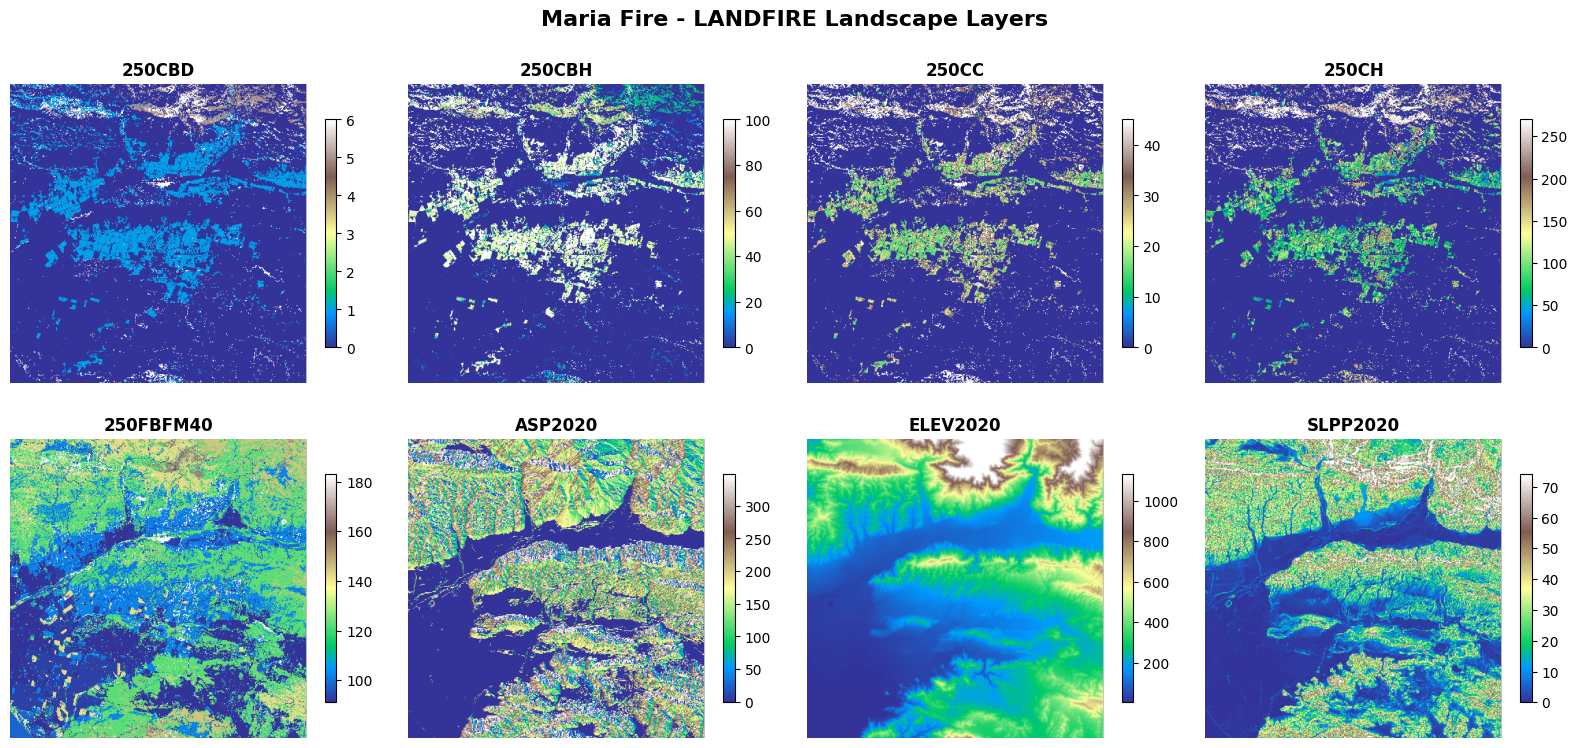

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

with rasterio.open(multi_tif) as src:
    for i, layer_name in enumerate(layer_names):
        band = src.read(i + 1).astype(float)
        band[band == src.nodata] = np.nan  # Mask nodata
        
        # Plot
        vmin, vmax = np.nanpercentile(band, [2, 98])
        im = axes[i].imshow(band, cmap="terrain", vmin=vmin, vmax=vmax)
        axes[i].set_title(layer_name, fontweight="bold")
        axes[i].axis("off")
        plt.colorbar(im, ax=axes[i], shrink=0.6)

plt.suptitle(f"{FIRE_NAME} - LANDFIRE Landscape Layers", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## Summary

**Downloaded files location:**
```
landfire_<fire_name>/
├── 250CBD.asc        # Canopy Bulk Density
├── 250CBH.asc        # Canopy Base Height
├── 250CC.asc         # Canopy Cover
├── 250CH.asc         # Canopy Height
├── 250FBFM40.asc     # Fuel Models
├── ASP2020.asc       # Aspect
├── ELEV2020.asc      # Elevation
└── SLPP2020.asc      # Slope
```

**Next steps: Use these `.asc` files to generate a FARSITE `.lcp` file.**


---

**Reference:**
- [LANDFIRE Product Service API](https://lfps.usgs.gov/)
- [LANDFIRE Data Products](https://landfire.gov/)
- [FBFM40 Fuel Models](https://landfire.gov/fbfm40.php)